# Prototyping

Creates a neural network which evaluates a time series and produce a set of predicted values for the time series
Predicted values may be used in a policy to make a trade. This policy may be modeled by simple multiple regression or a neural network.

## Data
Test data is taken as most recent to avoid lookahead bias. Train data is split into a validation and training set during fitting.


## TODO
- Adding VIX as a signal
- Adding High/Low as signals
- Multiple securities/ aggregate samples
- Policy network
- Regularization (l2)
- Dilated convolution

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pandas_datareader as pdr
from datetime import datetime
from scipy import stats


NUM_INPUT_NEURONS = 32
NUM_OUTPUT_NEURONS = 1
DAY_OFFSET = 5

def from_network(symbol):
    return pdr.get_data_yahoo(symbols=symbol, start=datetime(1900, 1, 1))

def from_file(symbol):
    dataset_path = keras.utils.get_file("{}.csv".format(symbol), "http://localhost:8000/data/daily/{}.csv".format(symbol))
    column_names = ['Date','Open','High','Low','Close','Adj Close','Volume'] 
    return pd.read_csv(dataset_path, 
                              names=column_names, 
                              dtype={'Close': np.float64,'Open': np.float64,'High': np.float64,'Adj Close': np.float64, 'Volume': np.float64},
                              header=0,
                              na_values = "?", 
                              comment='\t',
                              sep=",",
                              skipinitialspace=True)


# Create features (only close price for now)
def convert_to_percentage(old, new):
    return (old - new) / old

def convert_labels_to_category(labels): 
    # Simplification - If positive return, 1, else 0
    # return map(lambda arr: 1 if arr[0] > 1 else 0, labels)
    # rounding simpliciation
    return map(lambda arr: map(lambda val: round(val,4),arr), labels)

def convert_to_train(raw_dataset, offset=5):
    dataset = raw_dataset.copy()
    features = []
    labels = []
    for i in range(offset, len(dataset) - NUM_INPUT_NEURONS):

        feature_dataset = dataset[i:i+NUM_INPUT_NEURONS].copy()
        latest_close = feature_dataset['Close'].iloc[0]
        
        close_features = feature_dataset['Close'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        high_features = feature_dataset['High'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        low_features = feature_dataset['Low'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        open_features = feature_dataset['Open'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        features.append(
            zip(
                close_features,
                high_features,
                low_features,
                open_features,
            )
        )
        labels.append([
            dataset['Close'].iloc[i-1] / latest_close, # 1 day trade
#             dataset['Close'].iloc[i-2] / latest_close, # 2 day trade
#             dataset['Close'].iloc[i-3] / latest_close, # 3 day trade
#             dataset['Close'].iloc[i-4] / latest_close, # 4 day trade
#             dataset['Close'].iloc[i-5] / latest_close, # 5 day trade
        ])
        
    # Without converting labels the precision is hard to determine accuracy. 
    # Rather than crude 0/1, maybe this can be more sophisticated
    labels = convert_labels_to_category(labels)
    
    return [features,labels]
def split_data(symbol):
    fetched = from_network(symbol).sort_values(by=['Date'],ascending=False)
    converted = convert_to_train(fetched)
    features = converted[0]
    labels = converted[1]
    prediction = [
        features[:5],
        labels[:5],
    ]
    validation = [
        features[5:1000],
        labels[5:1000]
    ]
    training = [
        features[1000:],
        labels[1000:]
    ]
    return {
        'symbol': symbol,
        'prediction': prediction,
        'validation': validation,
        'training': training,
    }


In [2]:

#dataset = raw_dataset.copy()
#dataset = from_network('SPY').sort_values(by=['Date'],ascending=False)
# add function to cache fetch
QQQ = from_network('QQQ')
SPY = from_network('SPY')
XLK = from_network('XLK')
XLF = from_network('XLF')
XLE = from_network('XLE')
XLP = from_network('XLP')
XLV = from_network('XLV')
XLY = from_network('XLY')
XLI = from_network('XLI')
XLU = from_network('XLU')

#dataset = pd.concat([QQQ,SPY,XLK,XLF,XLE,XLP,XLV,XLY,XLI,XLU]).sort_values(by=['Date'],ascending=False)



In [3]:

prepped_data = map(split_data, [
    'QQQ',
    'SPY',
#     'XLK',
#     'XLF',
#     'XLE',
#     'XLP',
#     'XLV',
#     'XLY',
#     'XLI',
#     'XLU',
])


In [4]:

for i in range(len(prepped_data)):
    print prepped_data[i]['symbol']
    
def combine_all(accum, prep):
    
    print len(accum['training'][0])
    return {   
        'prediction':[
            accum['prediction'][0] + prep['prediction'][0],
            accum['prediction'][1] + prep['prediction'][1],
        ],
        'validation':[
            accum['validation'][0] + prep['validation'][0],
            accum['validation'][1] + prep['validation'][1],
        ],
        'training':[
            accum['training'][0] + prep['training'][0],
            accum['training'][1] + prep['training'][1],
        ],
    }
combined = reduce(combine_all, prepped_data,{
    'prediction':[[],[]],
    'validation':[[],[]],
    'training':[[],[]],
})


QQQ
SPY
0
3966


In [5]:

#init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
len(combined['training'][0])

9474

In [6]:
#len(converted_feature_set[0][0])
print len(combined['training'][0])
train_data = np.array(combined['training'][0])
train_labels = np.array(combined['training'][1])

print len(combined['validation'][0])
test_data = np.array(combined['validation'][0])
test_labels = np.array(combined['validation'][1])

print len(combined['prediction'][0])
prediction_data = np.array(combined['prediction'][0])
prediction_labels = np.array(combined['prediction'][1])


9474
1990
10


In [25]:
#print train_data
#print train_labels

In [8]:

def build_model():
  model = keras.Sequential([
    #layers.Dense(64, activation=tf.nn.relu, input_shape=[NUM_INPUT_NEURONS]),
    layers.Conv1D(32, kernel_size=(5), strides=(1),
        activation='relu',
        input_shape=(32,4)),
#    layers.MaxPooling1D(3),
    layers.Flatten(),

    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(24, activation=tf.nn.relu),
    layers.Dense(12, activation=tf.nn.relu),

      
#     layers.Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(48, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(36, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(24, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(12, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
    layers.Dense(NUM_OUTPUT_NEURONS)
  ])

  model.compile(
#       loss='mean_squared_logarithmic_error',
#       loss='mean_squared_error',
     loss='logcosh',
#       loss='mean_absolute_error',
                optimizer='sgd',
#                 metrics=[
#                     'mae',
#                 ]
               )
  return model

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 32)            672       
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                28704     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_4 (Dense)              (None, 12)                300       
__________

In [54]:
model.fit(
    train_data, train_labels,
    epochs=2, validation_split = 0.2, verbose=1,
    callbacks=[tensorboard]
)
history = model.fit(
    train_data, train_labels,
    epochs=60, validation_split = 0.2, verbose=1,
    callbacks=[tensorboard]
)

Train on 7579 samples, validate on 1895 samples
Epoch 1/2
7579/7579 [==============================] - 1s 66us/step - loss: 1.3486e-04 - val_loss: 5.5197e-05
Epoch 2/2
7579/7579 [==============================] - 0s 63us/step - loss: 1.3480e-04 - val_loss: 5.5681e-05
Train on 7579 samples, validate on 1895 samples
Epoch 1/60
7579/7579 [==============================] - 1s 69us/step - loss: 1.3480e-04 - val_loss: 5.5143e-05
Epoch 2/60
7579/7579 [==============================] - 1s 70us/step - loss: 1.3475e-04 - val_loss: 5.5137e-05
Epoch 3/60
7579/7579 [==============================] - 1s 68us/step - loss: 1.3479e-04 - val_loss: 5.5116e-05
Epoch 4/60
7579/7579 [==============================] - 1s 68us/step - loss: 1.3473e-04 - val_loss: 5.5323e-05
Epoch 5/60
7579/7579 [==============================] - 1s 68us/step - loss: 1.3472e-04 - val_loss: 5.5362e-05
Epoch 6/60
7579/7579 [==============================] - 1s 66us/step - loss: 1.3464e-04 - val_loss: 5.5524e-05
Epoch 7/60
7579/75

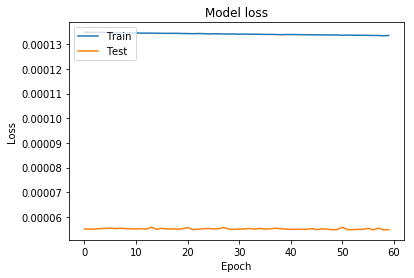

In [55]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [56]:
outputs = model.predict(test_data)

In [57]:

print stats.describe(test_labels)
print stats.describe(outputs)

DescribeResult(nobs=1990, minmax=(array([0.9542]), array([1.0624])), mean=array([1.00040372]), variance=array([9.89254361e-05]), skewness=array([-0.34777366]), kurtosis=array([4.06081482]))
DescribeResult(nobs=1990, minmax=(array([0.9917507], dtype=float32), array([1.0081553], dtype=float32)), mean=array([1.0001328], dtype=float32), variance=array([2.3961315e-06], dtype=float32), skewness=array([0.56681484], dtype=float32), kurtosis=array([3.823104], dtype=float32))


In [58]:
print outputs[0]
print test_labels[0]
print test_data[0]


[0.9999989]
[0.9963]
[[ 0.         -0.00055801  0.01599704  0.01041662]
 [ 0.00285213 -0.00148813  0.0112227   0.00706845]
 [ 0.01091266  0.00725445  0.02529763  0.01078872]
 [ 0.01977928  0.01500495  0.03205604  0.02889387]
 [ 0.03131202  0.02653769  0.05915174  0.05543156]
 [ 0.0710565   0.04972721  0.07310264  0.0538194 ]
 [ 0.0396825   0.03428819  0.06448409  0.06380204]
 [ 0.04352681  0.03906252  0.05313735  0.04265876]
 [ 0.05152528  0.03528027  0.05927578  0.04420886]
 [ 0.05102924  0.05022325  0.08804562  0.06764635]
 [ 0.05468745  0.0541915   0.10658484  0.10044641]
 [ 0.11024305  0.0824653   0.11049102  0.09424601]
 [ 0.08500739  0.04458087  0.09027776  0.05102924]
 [ 0.0557416   0.03354417  0.06752232  0.04420886]
 [ 0.04185268  0.00347221  0.04923117  0.01922127]
 [ 0.01773314  0.00824654  0.02628972  0.01630707]
 [ 0.02387157 -0.00241815  0.03168403  0.00551835]
 [ 0.00124006 -0.015687    0.00359624 -0.01196682]
 [-0.02368556 -0.03435025 -0.01705109 -0.03007196]
 [-0.02337

In [59]:
# primitive policy temporarily in place of a RL policy network

# signal step for our policy network
signals = map(lambda arr: sum(arr) / len(arr),outputs)
# signals = map(lambda arr: arr[0],outputs)
trades = map(lambda signal: 1 if round(signal,4) > 1 else 0,signals)

In [60]:
# one day return
actual = map(lambda arr: arr[0],test_labels)

df = pd.DataFrame({
    'signal':signals,
    'actual': actual,
    'trade':trades,
})

In [61]:
df['entry_success'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 1) else 0,axis=1)
df['entry_failure'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 1) else 0,axis=1)
df['avoid_success'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 0) else 0,axis=1)
df['avoid_failure'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 0) else 0,axis=1)


In [62]:
# primitive policy - replace with a policy network which maximizes reward
def label_success (row):
    return 0 if (row['entry_failure'] == 1 or row['entry_failure'] == 1) else 1

success = df.apply (lambda row: label_success (row),axis=1)
df['success'] = success;
df

,actual,signal,trade,entry_success,entry_failure,avoid_success,avoid_failure,success
0,0.9963,0.999999,0,0,0,1,0,1
1,1.0029,0.998994,0,0,0,0,1,1
2,1.0081,1.001618,1,1,0,0,0,1
3,1.0090,1.000459,1,1,0,0,0,1
4,1.0119,0.999805,0,0,0,0,1,1
5,1.0428,1.000054,1,1,0,0,0,1
6,0.9673,0.998201,0,0,0,1,0,1
7,1.0040,1.001339,1,1,0,0,0,1
8,1.0084,1.004279,1,1,0,0,0,1
9,0.9995,1.005271,1,0,1,0,0,0


In [63]:
print df['actual'].corr(df['signal'])
print df['actual'].corr(df['trade'])
print df['actual'].corr(df['entry_success'])
print df['actual'].corr(df['success'])


0.04235195089212175
0.020018278246728534
0.41465551622319835
0.4196964576256884


In [64]:
df['actual'].describe()

count    1990.000000
mean        1.000404
std         0.009946
min         0.954200
25%         0.996600
50%         1.000600
75%         1.005175
max         1.062400
Name: actual, dtype: float64

In [65]:
df['signal'].describe()

count    1990.000000
mean        1.000133
std         0.001548
min         0.991751
25%         0.999318
50%         1.000036
75%         1.000823
max         1.008155
Name: signal, dtype: float64

In [66]:
NUM_TEST_SAMPLES = len(test_data)
print NUM_TEST_SAMPLES

print '\nPrecision' # optimize for this since we can increase discovery, so long as we find enough trades
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['entry_failure'])) 

print '\nRecall'
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['avoid_failure']))

print '\nAccuracy'
print sum(df['entry_success']) * 1.00 / (NUM_TEST_SAMPLES)

print '\nNon-loss events'
print sum(df['success'])
print sum(df['success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nLose trades'
print sum(df['entry_failure'])
print sum(df['entry_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nWin trades'
print sum(df['entry_success'])
print sum(df['entry_success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nMissed opportunities'
print sum(df['avoid_failure'])
print sum(df['avoid_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nBullets dodged'
print sum(df['avoid_success'])
print sum(df['avoid_success']) / (NUM_TEST_SAMPLES * 1.00)


1990

Precision
0.550769230769

Recall
0.499534883721

Accuracy
0.269849246231

Non-loss events
1552
0.779899497487

Lose trades
438
0.220100502513

Win trades
537
0.269849246231

Missed opportunities
538
0.270351758794

Bullets dodged
460
0.231155778894


In [67]:
weights, biases = model.layers[0].get_weights()


In [68]:
list(weights)

[array([[ 0.00189589, -0.08340681,  0.06239806, -0.03416989, -0.1204368 ,
         -0.1119125 , -0.12959342, -0.11332761,  0.17328863,  0.0022723 ,
         -0.02248038,  0.1372904 ,  0.02308114,  0.03597886, -0.00024042,
          0.06198   ,  0.1413104 ,  0.0652935 ,  0.17251897, -0.06182472,
         -0.15720631, -0.14738251,  0.17121056,  0.08472145,  0.15413718,
         -0.13105005,  0.16324824, -0.17448615, -0.0084502 , -0.08476239,
          0.05675653, -0.00895276],
        [ 0.1495099 ,  0.16066135, -0.00362481, -0.16850182, -0.06312653,
          0.02063698,  0.15394612,  0.04161632,  0.15972283, -0.16459852,
          0.12565975, -0.06647352, -0.1591163 , -0.13607916,  0.14369775,
         -0.02244516,  0.14077286, -0.14586696, -0.05428725,  0.16857435,
          0.14634855,  0.11117543, -0.04610117,  0.10854615,  0.14961255,
         -0.08942042, -0.0064688 , -0.09485752,  0.04934951, -0.114145  ,
         -0.18017548,  0.15747216],
        [ 0.0292776 ,  0.06034708, -0.03

In [69]:
today_data = np.array(convert_to_train(SPY.copy(), 0)[0][:1])
today_data

array([[[ 0.        , -0.00071011,  0.00426743, -0.00071011],
        [-0.00711238, -0.00711238, -0.00071011, -0.00071011],
        [-0.00924496, -0.00995733, -0.00426743, -0.00640001],
        [-0.01991465, -0.02062476, -0.00995733, -0.01066743],
        [-0.02418208, -0.02631466, -0.01208991, -0.02346971],
        [-0.02346971, -0.02560455, -0.01777981, -0.02346971],
        [-0.02346971, -0.02702703, -0.02204724, -0.02346971],
        [-0.01635734, -0.01991465, -0.01422475, -0.01991465],
        [-0.01777981, -0.01849218, -0.01351238, -0.01635734],
        [-0.0227596 , -0.02702703, -0.01920229, -0.01920229],
        [-0.01493486, -0.02133713, -0.01493486, -0.02133713],
        [ 0.01066969, -0.01208991,  0.01209217, -0.01208991],
        [ 0.0113798 ,  0.00924722,  0.01493712,  0.01066969],
        [ 0.01209217,  0.        ,  0.02560455,  0.        ],
        [ 0.00853485,  0.00853485,  0.01351464,  0.01209217],
        [ 0.00497979,  0.00355732,  0.00853485,  0.0056899 ],
        

In [70]:
future_prediction = model.predict(today_data)
future_prediction # [1 day prediction, 5 day prediction]

array([[0.9985657]], dtype=float32)